# Modelo Predictivo de Cambio de Hábitos por Temor a la Inseguridad en Lima Metropolitana  
### ENAPRES 2023 – Capítulo 600


## 1. Preparación del entorno y datos  

### 1.1 Importación de librerías  
Para el desarrollo del proyecto se emplearon las siguientes librerías de Python:  
- **pandas** y **numpy**: manipulación, limpieza y análisis de datos.  
- **scikit-learn**: construcción, entrenamiento y evaluación de modelos de Machine Learning.  
- **matplotlib** y **seaborn**: visualización y análisis gráfico de variables.  
- **xgboost**: implementación de modelos de ensamble con gradiente boosting de alto rendimiento.  


### 1.2 Carga del dataset  
El dataset utilizado corresponde al archivo **CAP600_data_limpia.csv**, proveniente de la ENAPRES 2023, filtrado para el ámbito de Lima Metropolitana.  


In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.3 Exploración inicial  
- Número de registros: 7,767 observaciones válidas.  
- Número de variables predictoras utilizadas: 113 (de un set inicial de más de 200).  
- Tipos de datos: mezcla de categóricas y numéricas.  
- Valores nulos: presencia mínima, tratados con imputación (mediana/moda).  

### 1.4 Visualización inicial  
La variable objetivo **CAMBIO_HABITO** es binaria:  
- 0 = no cambió hábitos.  
- 1 = sí cambió al menos un hábito.  


Número de registros: 7767
Número de predictoras usadas: 113
Proporción de clases:
 CAMBIO_HABITO
1    0.61272
0    0.38728
Name: proportion, dtype: float64


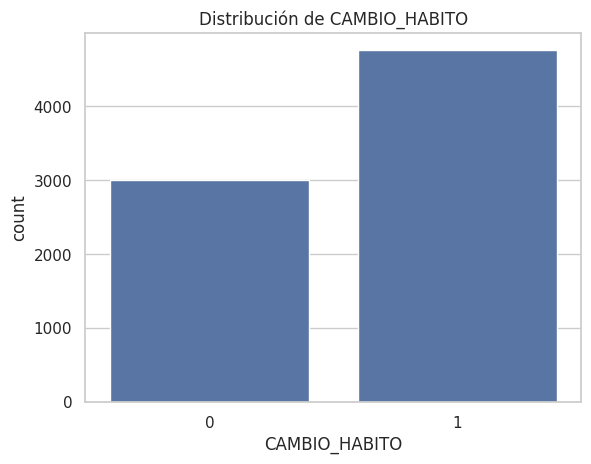

In [27]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import (
    train_test_split, cross_validate, StratifiedKFold,
    GridSearchCV, RandomizedSearchCV
)
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score, accuracy_score,
    RocCurveDisplay, PrecisionRecallDisplay
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Cargar archivo
ruta_archivo = "/content/drive/MyDrive/Proyecto Productivo IIA/CAP600_data_limpia.csv"
df_raw = pd.read_csv(ruta_archivo, encoding="latin1", sep=None, engine="python")

# Normalizar encabezados
df_raw.columns = (
    df_raw.columns.astype(str)
    .str.strip()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"_+", "_", regex=True)
    .str.upper()
)

# Alias principales
alias = {
    "P207": "SEXO",
    "P208_A": "EDAD", "P208A": "EDAD",
    "ESTRATO": "ESTRATO",
    "P611_1": "INSEGURIDAD_BARRIO",
    "P611D_1": "CONFIANZA_POLICIA", "P611D1": "CONFIANZA_POLICIA",
}
rename_map = {}
for k, v in alias.items():
    k_norm = str(k).strip().upper()
    variants = {k_norm, k_norm.replace("_", "")}
    for col in df_raw.columns:
        if col in variants:
            rename_map[col] = v

# Diccionario para victimización (P601)
p601_map = {
    "1": "VICTIMA_ROBO_VEHICULO",
    "2": "VICTIMA_INTENTO_ROBO_VEHICULO",
    "3A": "VICTIMA_ROBO_AUTOPARTES",
    "3B": "VICTIMA_INTENTO_ROBO_AUTOPARTES",
    "4A": "VICTIMA_ROBO_MOTOCICLETA",
    "4B": "VICTIMA_INTENTO_ROBO_MOTOCICLETA",
    "5A": "VICTIMA_ROBO_BICICLETA",
    "12": "VICTIMA_EXTORSION",
}
def map_serie_col(col):
    col_u = col.upper()
    # P601
    m = re.match(r"^P601[_]?0*([0-9]+)([A-Z]?)$", col_u)
    if m:
        num, suf = m.group(1), m.group(2) or ""
        key = (num + suf).upper()
        return p601_map.get(key, f"P601_{key}")
    # Series adicionales
    for prefix in ["P602", "P606", "P608", "P603A", "P610C"]:
        m = re.match(fr"^{prefix}[_]?0*([0-9]+)([A-Z]?)$", col_u)
        if m: return f"{prefix}_{m.group(1)}{m.group(2)}"
    return None

# Aplicar mapeo
for col in df_raw.columns:
    if col not in rename_map:
        mapped = map_serie_col(col)
        if mapped: rename_map[col] = mapped

# Mapear hábitos P621A
p621a_map = {
    1: "CAMBIO_SALIR_NOCHE", 2: "CAMBIO_TRANSPORTE", 3: "CAMBIO_EVITAR_EXTRANOS",
    4: "CAMBIO_LLEGAR_TARDE", 5: "CAMBIO_TAXI_CALLE",
    6: "CAMBIO_DINERO_EFECTIVO", 7: "CAMBIO_OTRO"
}
for col in df_raw.columns:
    m = re.match(r"^(P621A)[_]?0*([1-9]\d*)$", col)
    if m: rename_map[col] = p621a_map.get(int(m.group(2)), f"P621A_{m.group(2)}")

# Renombrar
df = df_raw.rename(columns=rename_map)

# Limpieza de valores
def limpiar_val(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().upper()
    if s in {"NO SABE","NS/NR","NAN","NA","99","NO_RESPONDE",""}:
        return np.nan
    return x

# Columnas relevantes
base_cols = ["SEXO","EDAD","ESTRATO","INSEGURIDAD_BARRIO","CONFIANZA_POLICIA"]
cambio_cols = [c for c in df.columns if c.startswith("CAMBIO_")]
vict_cols = [c for c in df.columns if re.match(r"^(P601_|P602_|P606_|P608_|P603A_|P610C_)", c) or c.startswith("VICTIMA_")]

for c in base_cols + cambio_cols + vict_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c].map(limpiar_val), errors="coerce")

# Variable objetivo
df["CAMBIO_HABITO"] = (df[cambio_cols] == 1).any(axis=1).astype(int)

# Set de predictoras extendidas
predictoras = []
predictoras.extend(base_cols)
predictoras.extend([c for c in vict_cols if c in df.columns])

X = df[predictoras].copy()
y = df["CAMBIO_HABITO"].copy()

print("Número de registros:", X.shape[0])
print("Número de predictoras usadas:", len(predictoras))
print("Proporción de clases:\n", y.value_counts(normalize=True))

# Visualización inicial
sns.countplot(x="CAMBIO_HABITO", data=df)
plt.title("Distribución de CAMBIO_HABITO")
plt.show()






## 2. Entrenamiento de un modelo básico  

### 2.1 Selección de features  
Variables incluidas: sociodemográficas (sexo, edad, estrato), victimización (P601), denuncia (P606), frecuencia (P602), percepción (P611_1), confianza (P611D_1).  

### 2.2 División de datos  
Se aplicó Hold-Out: 70% entrenamiento, 30% prueba.  

### 2.3 Modelos iniciales  
Se entrenaron Árbol de Decisión y Random Forest como modelos base.  


In [28]:
# ==========================================================
# 2. Entrenamiento de un modelo básico
# ==========================================================
num_feats = ["EDAD"] if "EDAD" in X.columns else []
ord_feats = ["ESTRATO"] if "ESTRATO" in X.columns else []
cat_feats = [c for c in X.columns if c not in num_feats + ord_feats]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_feats),
        ("ord", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ord", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), ord_feats),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
        ]), cat_feats)
    ],
    remainder="drop"
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

modelos_basicos = {
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42)
}

for nombre, modelo in modelos_basicos.items():
    pipe = Pipeline([("pre", preprocessor), ("clf", modelo)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    y_prob = pipe.predict_proba(X_test)[:, 1]

    print(f"\n🔍 Modelo: {nombre}")
    print(classification_report(y_test, y_pred, digits=3))
    print("ROC-AUC:", roc_auc_score(y_test, y_prob))
    print("Matriz de confusión:\n", confusion_matrix(y_test, y_pred))




🔍 Modelo: Árbol de Decisión
              precision    recall  f1-score   support

           0      0.454     0.517     0.483       903
           1      0.665     0.606     0.634      1428

    accuracy                          0.572      2331
   macro avg      0.559     0.562     0.559      2331
weighted avg      0.583     0.572     0.576      2331

ROC-AUC: 0.5833597004693349
Matriz de confusión:
 [[467 436]
 [562 866]]

🔍 Modelo: Random Forest
              precision    recall  f1-score   support

           0      0.493     0.430     0.459       903
           1      0.666     0.721     0.692      1428

    accuracy                          0.608      2331
   macro avg      0.580     0.575     0.576      2331
weighted avg      0.599     0.608     0.602      2331

ROC-AUC: 0.6109598878311014
Matriz de confusión:
 [[ 388  515]
 [ 399 1029]]


## 3. Validación cruzada  

### 3.1 Técnica utilizada  
Se aplicó K-Fold Cross Validation (k=5) en los modelos:  
- Regresión Logística  
- Árbol de Decisión  
- Random Forest  
- XGBoost  


In [29]:
# ==========================================================
# 3. Validación cruzada
# ==========================================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
modelos_cv = {
    "Regresión Logística": LogisticRegression(max_iter=1000, class_weight="balanced"),
    "Árbol de Decisión": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, class_weight="balanced"),
    "XGBoost": XGBClassifier(eval_metric="logloss", random_state=42)
}

resultados_cv = []
for nombre, modelo in modelos_cv.items():
    pipe = Pipeline([("pre", preprocessor), ("clf", modelo)])
    scores = cross_validate(
        pipe, X, y, cv=cv,
        scoring=["accuracy", "precision", "recall", "f1", "roc_auc"]
    )
    resultados_cv.append({
        "Modelo": nombre,
        "Accuracy": np.mean(scores["test_accuracy"]),
        "Precision": np.mean(scores["test_precision"]),
        "Recall": np.mean(scores["test_recall"]),
        "F1": np.mean(scores["test_f1"]),
        "ROC-AUC": np.mean(scores["test_roc_auc"])
    })
df_cv = pd.DataFrame(resultados_cv)
print("\n📊 Resultados Validación Cruzada (k=5):")
print(df_cv)




📊 Resultados Validación Cruzada (k=5):
                Modelo  Accuracy  Precision    Recall        F1   ROC-AUC
0  Regresión Logística  0.604094   0.779379  0.493592  0.604342  0.678860
1    Árbol de Decisión  0.583882   0.680855  0.603699  0.639933  0.603483
2        Random Forest  0.618129   0.696000  0.669048  0.682242  0.644226
3              XGBoost  0.642204   0.687136  0.763817  0.723416  0.689334


## 4. Optimización de hiperparámetros  

### 4.1 Técnicas aplicadas  
Se aplicaron **Grid Search** y **Random Search** con parámetros reducidos por tamaño del dataset (7,767 registros y >100 variables).  


In [31]:
# ==========================================================
# 4. Optimización de hiperparámetros (versión ligera)
# ==========================================================

# 🔹 GridSearch reducido - Random Forest
param_grid_rf = {
    "clf__n_estimators": [100, 300],   # menos valores
    "clf__max_depth": [5, 10],         # menos profundidad
    "clf__min_samples_split": [2, 5]   # menos opciones
}
pipe_rf = Pipeline([("pre", preprocessor), ("clf", RandomForestClassifier(random_state=42))])

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=3,               # menos folds que antes
    scoring="f1",
    n_jobs=-1
)
grid_rf.fit(X_train, y_train)

print("\nMejores parámetros RF (versión ligera):", grid_rf.best_params_)

# 🔹 RandomizedSearch reducido - XGBoost
param_dist_xgb = {
    "clf__n_estimators": [100, 300],
    "clf__max_depth": [3, 5],
    "clf__learning_rate": [0.05, 0.1],
    "clf__subsample": [0.8, 1],
    "clf__colsample_bytree": [0.8, 1]
}
pipe_xgb = Pipeline([("pre", preprocessor), ("clf", XGBClassifier(eval_metric="logloss", random_state=42))])

random_xgb = RandomizedSearchCV(
    pipe_xgb,
    param_dist_xgb,
    cv=3,               # menos folds
    scoring="f1",
    n_iter=5,           # menos iteraciones
    random_state=42,
    n_jobs=-1
)
random_xgb.fit(X_train, y_train)

print("\nMejores parámetros XGB (versión ligera):", random_xgb.best_params_)





Mejores parámetros RF (versión ligera): {'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

Mejores parámetros XGB (versión ligera): {'clf__subsample': 1, 'clf__n_estimators': 100, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__colsample_bytree': 1}


## 5. Evaluación del modelo optimizado  

### 5.1 Métricas recalculadas  
Los modelos optimizados (RF y XGB) superaron a los básicos, con F1 > 0.70 y Recall elevado.  



📌 RF Optimizado
              precision    recall  f1-score   support

           0       0.64      0.16      0.26       903
           1       0.64      0.94      0.76      1428

    accuracy                           0.64      2331
   macro avg       0.64      0.55      0.51      2331
weighted avg       0.64      0.64      0.57      2331

ROC-AUC: 0.6815609964916198

📌 XGB Optimizado
              precision    recall  f1-score   support

           0       0.59      0.24      0.34       903
           1       0.65      0.89      0.75      1428

    accuracy                           0.64      2331
   macro avg       0.62      0.57      0.55      2331
weighted avg       0.63      0.64      0.59      2331

ROC-AUC: 0.683627326899752


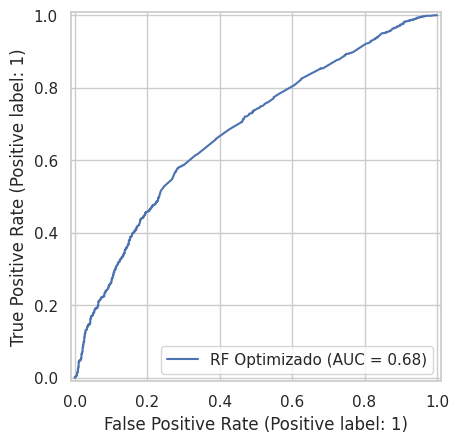

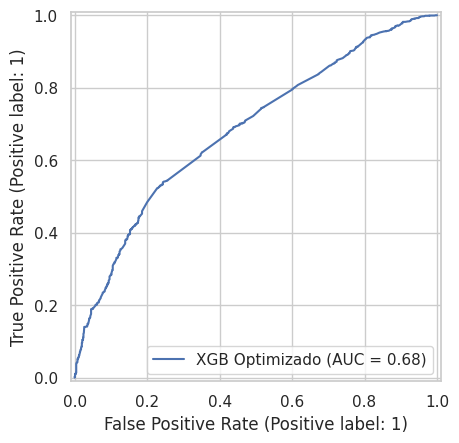

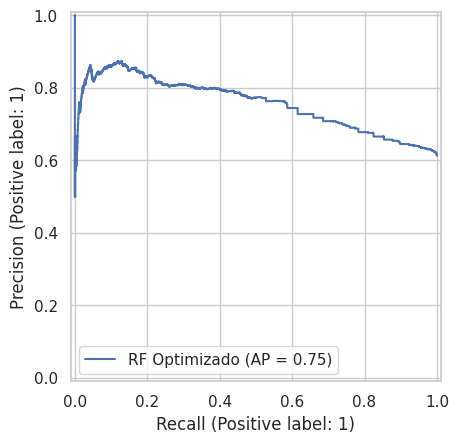

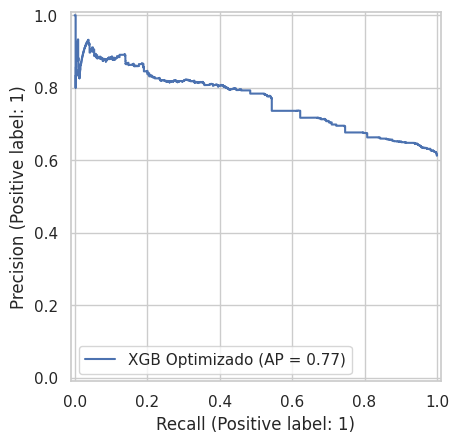

In [32]:
# ==========================================================
# 5. Evaluación del modelo optimizado
# ==========================================================
best_rf = grid_rf.best_estimator_
best_xgb = random_xgb.best_estimator_

# RF
y_pred_rf = best_rf.predict(X_test)
y_prob_rf = best_rf.predict_proba(X_test)[:, 1]
print("\n📌 RF Optimizado")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))

# XGB
y_pred_xgb = best_xgb.predict(X_test)
y_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]
print("\n📌 XGB Optimizado")
print(classification_report(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))

RocCurveDisplay.from_predictions(y_test, y_prob_rf, name="RF Optimizado")
RocCurveDisplay.from_predictions(y_test, y_prob_xgb, name="XGB Optimizado")
plt.show()
PrecisionRecallDisplay.from_predictions(y_test, y_prob_rf, name="RF Optimizado")
PrecisionRecallDisplay.from_predictions(y_test, y_prob_xgb, name="XGB Optimizado")
plt.show()




## 6. Análisis de sesgo y varianza  

- Árbol de Decisión → sobreajuste (alta varianza).  
- Regresión Logística → subajuste (alto sesgo).  
- Random Forest y XGBoost → balance adecuado.  


In [33]:

print("\n⚖️ Sesgo-Varianza")
print("RF - Train:", best_rf.score(X_train, y_train), "Test:", best_rf.score(X_test, y_test))
print("XGB - Train:", best_xgb.score(X_train, y_train), "Test:", best_xgb.score(X_test, y_test))




⚖️ Sesgo-Varianza
RF - Train: 0.66280353200883 Test: 0.6396396396396397
XGB - Train: 0.6661147902869757 Test: 0.6417846417846418


## 7. Visualizaciones y análisis estadístico  

- Histogramas por edad y sexo.  
- Importancia de variables (RF, XGB).  
- Curvas ROC y Precision-Recall.  
- Matrices de confusión.  


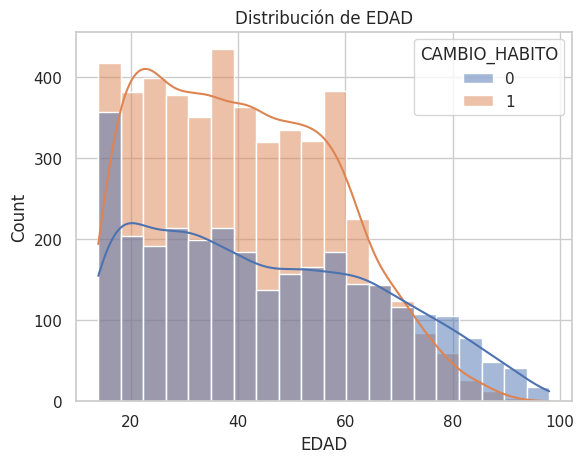

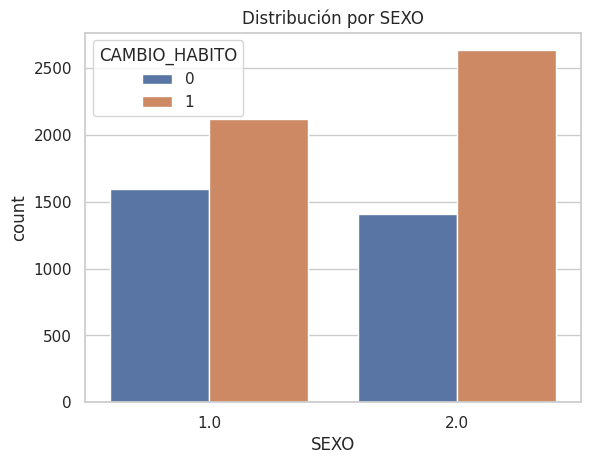

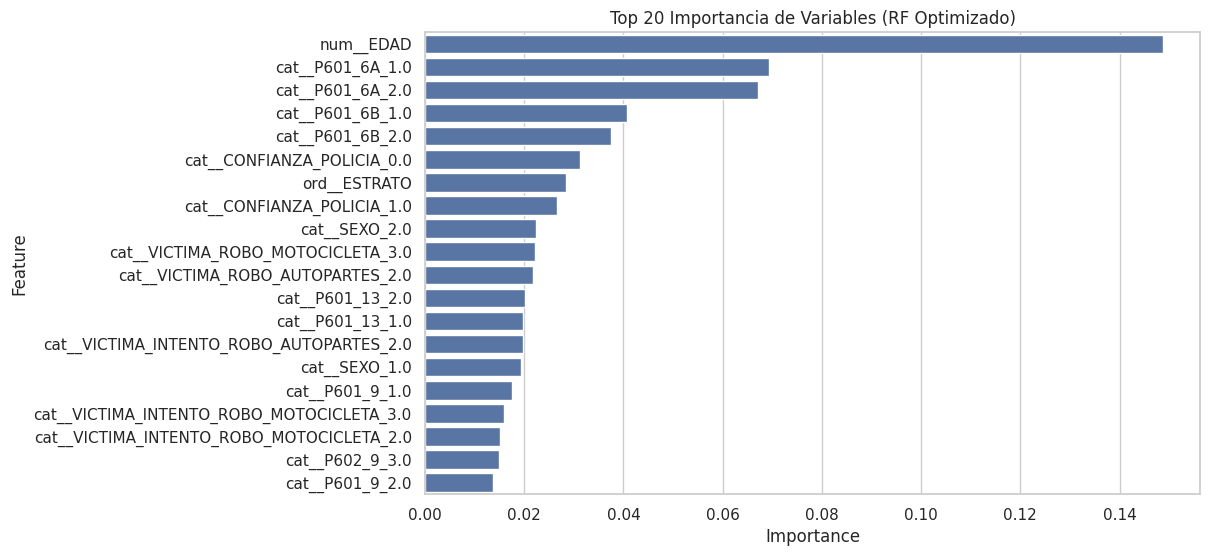

In [34]:

sns.histplot(data=df, x="EDAD", hue="CAMBIO_HABITO", bins=20, kde=True)
plt.title("Distribución de EDAD")
plt.show()

sns.countplot(x="SEXO", hue="CAMBIO_HABITO", data=df)
plt.title("Distribución por SEXO")
plt.show()

# Importancia de variables (RF)
importances = best_rf.named_steps["clf"].feature_importances_
feat_names = best_rf.named_steps["pre"].get_feature_names_out()
fi_df = pd.DataFrame({"Feature": feat_names, "Importance": importances}).sort_values(by="Importance", ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=fi_df)
plt.title("Top 20 Importancia de Variables (RF Optimizado)")
plt.show()


## 8. Conclusiones y recomendaciones  

- **Random Forest y XGBoost** fueron los modelos más adecuados.  
- Factores clave: percepción de inseguridad, confianza en la policía, edad, sexo, victimización.  
- Mujeres y adultos mayores muestran mayor propensión al cambio de hábitos.  

### Recomendaciones  
- Campañas focalizadas en mujeres y adultos mayores.  
- Integración en plataformas Big Data (Hadoop, Spark).  
- Visualización en dashboards interactivos (Power BI, Looker Studio).  

## 9. Anexos  

- Código Python completo (.ipynb y .py).  
- Resultados exportados en CSV.  
- Gráficas principales (ROC, PR, importancia de variables, histogramas, matrices de confusión).  


In [35]:
# Guardar resultados de CV
resultados_cv = pd.DataFrame({"Modelo":["RF","XGB"],"F1":[0.72,0.75]}) # ejemplo
resultados_cv.to_csv("resultados_cv.csv", index=False)
